<a href="https://colab.research.google.com/github/cristina2003pg/Python-Intro-for-Data-Science-/blob/kaggle-challenge/Challenge_M%C3%B3dulo_5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge

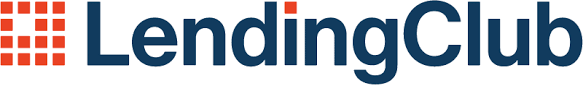

*Lending Club es una compañía estadounidense de préstamo entre particulares, con sede en San Francisco.*

Este dataset contiene datos para todos los préstamos emitidos durante el período 2007-2011, incluido el estado actual del préstamo (actual, cancelado, totalmente pagado, etc.) y la información de pago más reciente.

## **Objetivo**

Encuentra el modelo y su conjunto de hiperparámetros que mejor predicen si un crédito tiene o no riesgo


* **grade**: calificación del préstamo
* **sub_grade**: subgrado del préstamo
* **short_emp**: un año o menos de empleo del prestatario
* **emp_length_num**: número de años de empleo  del prestatario
* **home_ownership**: estado de propiedad de vivienda: propio (own), hipoteca (mortgage) o alquiler(rent)
* **dti**: relación deuda-ingresos
* **purpose**: propósito del préstamo
* **term**: plazo del préstamo
* **last_delinq_none**: ¿el prestatario ha tenido algún impago?
* **last_major_derog_none**: ¿el prestatario ha tenido una calificación de 90 días o peor?
* **revol_util**: porcentaje de crédito disponible utilizado
* **total_rec_late_fee**: total de cargos por pagos atrasados recibidos hasta la fecha

Target/Objetivo de predicción:
* **bad_loans**: (+1 significa crédito riesgo, 0 es seguro)

## Funciones

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Hacer print con el texto en negrita
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
# Creamos una función que imprime por pantalla características importantes de los datos
def inspect_data(df):
    printmd('Data Shape')
    print(df.shape)
    print('\n')
    printmd('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    printmd('Data Types: ')
    print(df.dtypes)

In [ ]:
def plottingRegressComparison(yreal,ypred):

    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})

    i=min(ypred)
    comparison["line"] = [i+j*max(yreal)/len(comparison) for j in range(len(comparison))]
    comparison["line2"] = comparison["line"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
    comparison.plot.scatter(x="yreal", y="ypred", ax=ax)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_xticklabels(ax.get_xticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_ylabel("Ventas predichas", fontname='Serif', fontsize=10)
    ax.set_xlabel("Ventas reales", fontname='Serif', fontsize=10)
    ax.set_title("Ventas reales VS Ventas predichas", fontname='Serif', fontsize=10)
    ax.get_legend().remove()

In [ ]:
def plottingResults(yreal,ypred):
    # Creamos
    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})
    comparison["diff"] = comparison["yreal"] - comparison["ypred"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison["diff"].hist(bins=100, ax=ax)
    ax.set_xticklabels(ax.get_xticks(),fontsize=10, rotation=45)
    ax.set_yticklabels(ax.get_yticks(),fontsize=10)
    ax.set_xlabel("Error", fontname='Serif', fontsize=10)
    ax.set_title("Histograma del error de predicción", fontname='Serif', fontsize=16)

# **Preprocessing Data Functions**

## Missing data

In [ ]:
def meanValueImputation(data, feature):
    """
    Completa los valores vacíos en una columna de un DataFrame con el valor medio de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor medio de la columna
    valor_medio = data[feature].mean()

    # Completa los valores vacíos con el valor medio
    data[feature].fillna(valor_medio, inplace=True)

In [ ]:
from scipy import stats
def modeValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna de un DataFrame con el valor moda de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor moda de la columna
    valor_moda = stats.mode(data[feature])[0][0]

    # Completa los valores vacíos con el valor moda
    data[feature].fillna(valor_moda, inplace=True)

In [ ]:
def mostCommonValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna categórica de un DataFrame con el valor más común (modo) de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor más común (modo) de la columna
    valor_mas_comun = data[feature].mode()[0]

    # Completa los valores vacíos con el valor más común
    data[feature].fillna(valor_mas_comun, inplace=True)

## Outliers

In [ ]:
def statisticalOutlierDetection(data, feature, thresholdmin=None,thresholdmax=None, drop=False):
  #Eliminamos outliers en base a un criterio estadístico
  if thresholdmax:
    print("dentro")
    data_clean = data.drop(data[data[feature]>=thresholdmax].index)
  else:
    data_clean = data.copy()

  if thresholdmin:
    data_clean = data_clean.drop(data_clean[data_clean[feature]<=thresholdmin].index)
  else:
    data_clean = data_clean.copy()

  data_clean.reset_index(drop=True, inplace=True)

  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))
  print(data_clean.shape)

  if drop==True:
    return data_clean
  else:
    return data

In [ ]:
def modelOutlierDetection(data, nf, n = 20, drop = False):
  ## LocalOutlierFactor: se basa en la idea de que las instancias de datos anómalas tienen una densidad de puntos diferente a la de las instancias de datos normales en su vecindario local.
  from sklearn.neighbors import LocalOutlierFactor
  # Creamos el objeto LOF y ajustamos los datos
  clf = LocalOutlierFactor(n_neighbors=n)  # número de vecinos más cercanos que se considerarán al calcular la densidad local de un punto de datos.
  y_pred = clf.fit_predict(np.array(nf))
  # Eliminamos los outliers de nuestro set de datos
  data_clean = data.copy()
  data_clean["outliers"] = y_pred
  data_clean.drop(data_clean[data_clean["outliers"]<0].index, inplace=True)
  data_clean.drop("outliers", axis=1, inplace=True)
  data_clean.reset_index(drop=True, inplace=True)
  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))

  if drop:
    return  data_clean
  else:
    return data

## Codificación

In [ ]:
from sklearn.preprocessing import LabelEncoder
def labelEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  le = LabelEncoder()
  data_cod = data.copy() # Creo un dataframe de plantilla porque no quiero modificar el original
  for col in categorical_features.columns:
      data_cod[col+"_cod"]=le.fit_transform(np.array(data_cod[col]))

  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def OHEncoding(data, categorical_features):
  ohe = OneHotEncoder()
  data_cod = data.copy()
  for col in categorical_features.columns:
    # Data a codificar
    X = np.array(data_cod[[col]])
    # Fit & transform
    ohe.fit(X)
    Xohe = ohe.transform(X).toarray()
    # Unimos al set de datos de partida
    dataohe = pd.DataFrame(Xohe, columns=data_cod[col].drop_duplicates().tolist())
    data_cod = pd.concat([data_cod,dataohe], axis=1)

  # Eliminamos las variables originales de nuestro set de datos
  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [ ]:
!pip install category_encoders
import category_encoders as ce
def binaryEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  data_cod = data.copy()
  # Creamos el objeto BinaryEncoder y ajustamos el dataframe
  encoder = ce.BinaryEncoder(cols=categorical_features)
  data_cod = encoder.fit_transform(data_cod)
  data_cod

  return data_cod

# Challenge notebook

## Importamos las librerías que vamos a utilizar

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## Carga y previsualización de datos

In [ ]:
data = pd.read_csv("challenge-lending_club_data_train.csv")

In [ ]:
data.shape

(80000, 68)

In [ ]:
features = ['grade',
             'sub_grade',
            'short_emp',
            'emp_length_num',
            'home_ownership',
            'dti',
            'purpose',
            'term',
            'last_delinq_none',
            'last_major_derog_none',
            'revol_util',
            'total_rec_late_fee',
           ]

target = 'bad_loans'

data = data[features + [target]]

Análisis de los datos

In [ ]:
inspect_data(data)

Data Shape

(80000, 13)




Missing Values: 

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
bad_loans                0
dtype: int64




Data Types: 

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
bad_loans                  int64
dtype: object


In [ ]:
data.describe()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.127587,6.264950,15.064076,0.590562,0.888988,53.174428,0.890305,0.187512
std,0.333632,3.730245,7.420169,0.491733,0.314150,26.216695,5.875062,0.390325
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,9.500000,0.000000,1.000000,33.700000,0.000000,0.000000
50%,0.000000,6.000000,14.830000,1.000000,1.000000,55.100000,0.000000,0.000000
75%,0.000000,11.000000,20.410000,1.000000,1.000000,74.300000,0.000000,0.000000
max,1.000000,11.000000,34.990000,1.000000,1.000000,128.100000,208.820000,1.000000


Analizamos el target

[Text(0, 0, '0'), Text(1, 0, '1')]

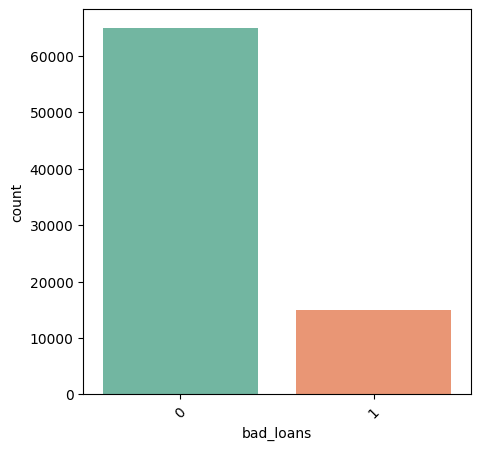

In [ ]:
target='bad_loans'
target_data = pd.DataFrame(data[target])

fix,ax = plt.subplots(figsize=(5,5))
sns.countplot(x=target,data=data,palette='Set2',ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

Analizamos las variables categóricas

In [ ]:
categorical_features = data.select_dtypes(include="object")
categorical_features.head(10)

,grade,sub_grade,home_ownership,purpose,term
0,B,B2,RENT,credit_card,36 months
1,C,C4,RENT,car,60 months
2,C,C5,RENT,small_business,36 months
3,C,C1,RENT,other,36 months
4,A,A4,RENT,wedding,36 months
5,E,E1,RENT,car,36 months
6,F,F2,OWN,small_business,60 months
7,B,B5,RENT,other,60 months
8,C,C3,OWN,debt_consolidation,60 months
9,B,B5,OWN,debt_consolidation,36 months


In [ ]:
categorical_features.apply(lambda x: len(x.unique()))

,0
grade,7
sub_grade,35
home_ownership,4
purpose,12
term,2


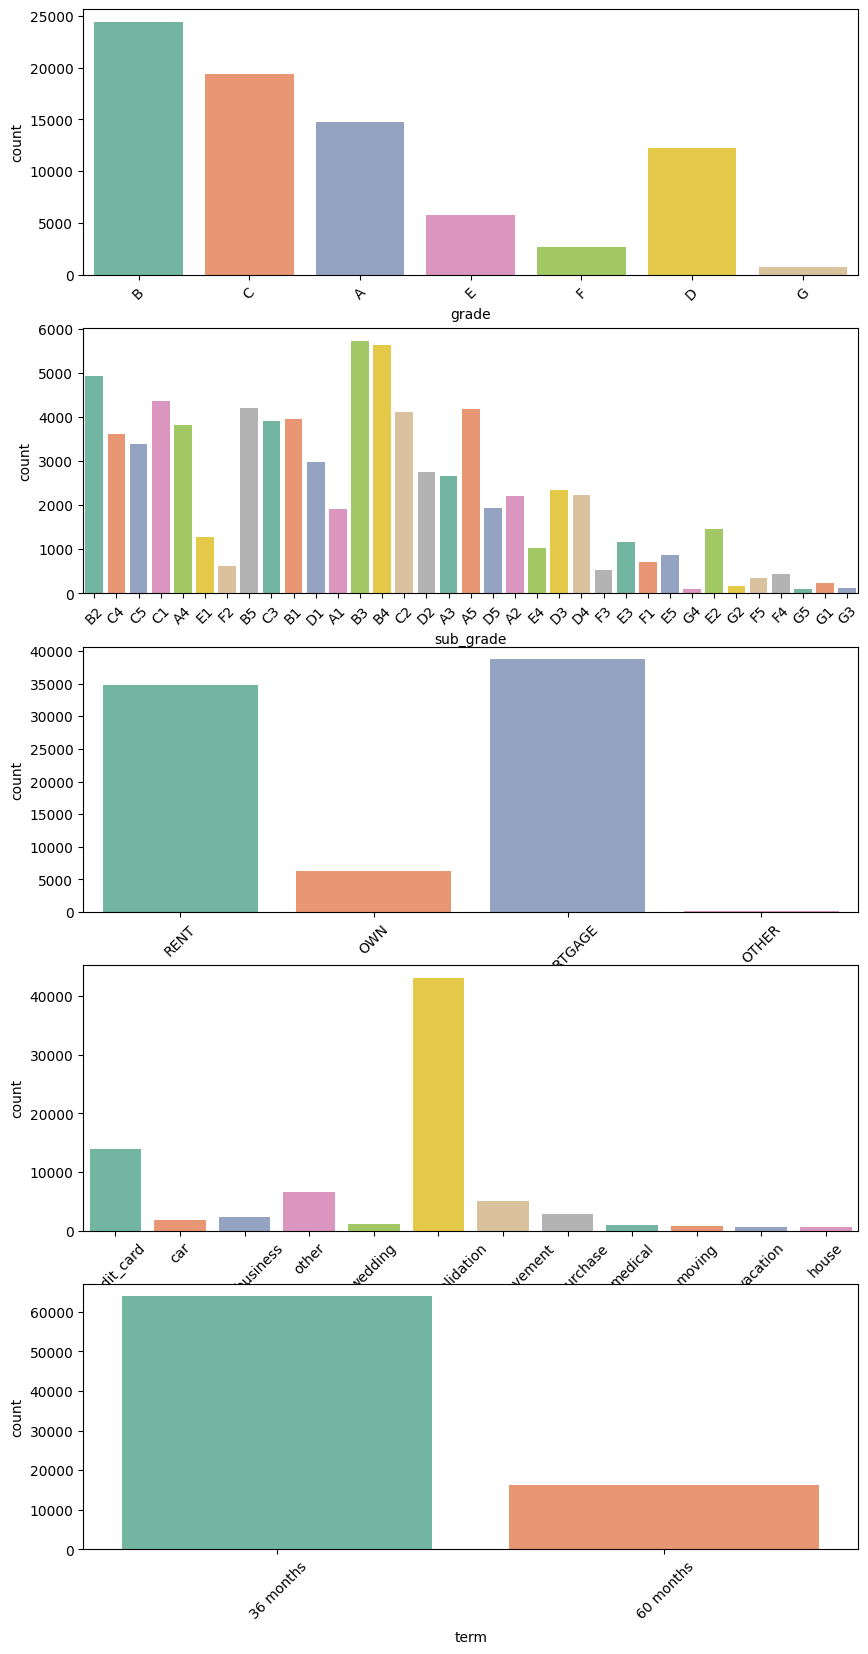

In [ ]:
fig, axs = plt.subplots (5, 1, figsize =(10,20))
catdata = categorical_features.columns
for col, ax in zip(catdata, axs.ravel()):
    sns.countplot(x=col,data=data,palette='Set2',ax=ax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)

A continuación, se analizan las variables numéricas


In [ ]:
numerical_features = data.select_dtypes(include=[np.number])
numerical_features.head(2)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
0,0,11,27.65,1,1,83.7,0.0,0
1,1,1,1.00,1,1,9.4,0.0,1


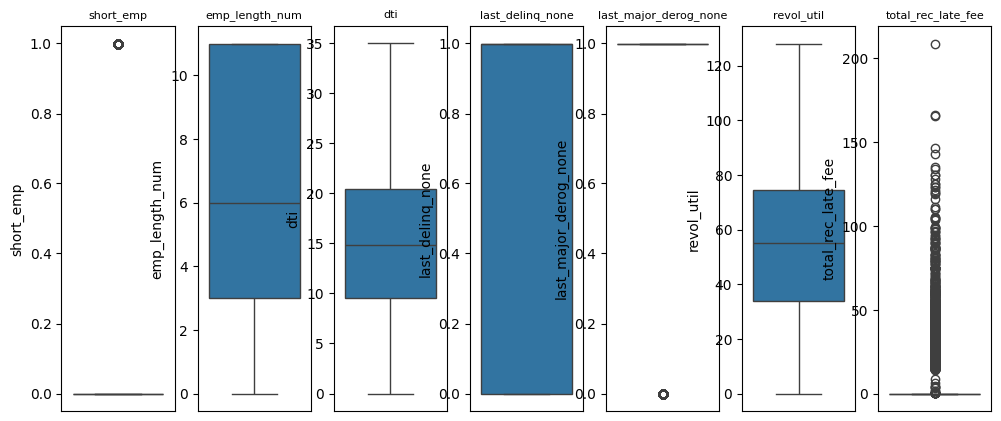

In [ ]:
fig, axs = plt.subplots(1,7,figsize=(12,5))
cols = numerical_features.columns[:-1]
for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(data=numerical_features[col], ax=ax)
  ax.get_xaxis().set_visible(False)
  ax.set_title(col, fontsize=8)

## Modelado 1

### Procesamiento de los datos

#### Balanceo del target

In [ ]:
safe_loans_raw = data[data[target]== 0]
risky_loans_raw = data[data[target]== 1]
printmd("Número de créditos seguros  :%s" % len(safe_loans_raw))
printmd("Número de créditos en riesgo :%s" % len(risky_loans_raw))

Número de créditos seguros  :64999

Número de créditos en riesgo :15001

In [ ]:
# calculamos el ratio de créditos de riesgo-crédito seguros, y dividimos la muesrras en subgrupos de seguros
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw

# generamos un array de forma aleatoria de valores comprendidos entre 0 y 1
msk = np.random.rand(len(safe_loans_raw)) < percentage
safe_loans = safe_loans_raw[msk]


In [ ]:
#Añadimos los créditos de riesgo a la versión submnuestreada de los créditos seguros
data = pd.concat([risky_loans_raw, safe_loans], ignore_index=True)

print("Porcentaje de créditos seguros                 :", len(safe_loans) / float(len(data)))
print("Porcentaje de créditos de riesgo                :", len(risky_loans_raw) / float(len(data)))
print("Número total de créditos en los nuevos datos   :", len(data))


Porcentaje de créditos seguros                 : 0.49691461533302034
Porcentaje de créditos de riesgo                : 0.5030853846669797
Número total de créditos en los nuevos datos   : 29818


In [ ]:
inspect_data(data)

Data Shape

(29818, 13)




Missing Values: 

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
bad_loans                0
dtype: int64




Data Types: 

grade                     object
sub_grade                 object
short_emp                  int64
emp_length_num             int64
home_ownership            object
dti                      float64
purpose                   object
term                      object
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
bad_loans                  int64
dtype: object


#### Imputación y outliers

In [ ]:
data_clean = data.copy()
data_clean.reset_index(drop=True, inplace=True)

In [ ]:
data_clean = data.loc[data["home_ownership"]!="OTHER"]
data_clean.reset_index(drop=True, inplace=True)

In [ ]:
data_clean = data_clean.drop(["short_emp", "total_rec_late_fee"], axis=1)

#### Codificación

In [ ]:
categorical_features.apply(lambda x: len(x.unique()))

,0
grade,7
sub_grade,35
home_ownership,4
purpose,12
term,2


In [ ]:
le = LabelEncoder()
data_cod = data_clean.copy()
for col in categorical_features.columns:
    data_cod[col+"_cod"]=le.fit_transform(np.array(data_cod[col]))

data_cod = data_cod.drop(categorical_features.columns, axis=1)
data_cod

,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,bad_loans,grade_cod,sub_grade_cod,home_ownership_cod,purpose_cod,term_cod
0,1,1.00,1,1,9.4,1,2,13,2,0,1
1,5,5.55,1,1,32.6,1,5,26,1,9,1
2,1,18.08,1,1,36.5,1,1,9,2,8,1
3,1,10.08,1,1,91.7,1,2,10,2,2,0
4,4,7.06,1,1,55.5,1,1,6,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...
29744,5,12.35,1,1,68.1,0,5,29,2,2,1
29745,2,2.08,1,1,19.3,0,0,2,2,9,0
29746,6,10.46,0,1,66.5,0,4,24,0,2,1
29747,3,22.25,0,1,43.6,0,1,8,0,2,0


#### Escalado

In [ ]:
# Escalado minmax
minmax_scaler = MinMaxScaler()
# Escalado minmax
data_scl = minmax_scaler.fit_transform(data_cod)
data_scl = pd.DataFrame(data_scl, columns=data_cod.columns)
data_scl

,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,bad_loans,grade_cod,sub_grade_cod,home_ownership_cod,purpose_cod,term_cod
0,0.090909,0.028588,1.0,1.0,0.073380,1.0,0.333333,0.382353,1.0,0.000000,1.0
1,0.454545,0.158662,1.0,1.0,0.254489,1.0,0.833333,0.764706,0.5,0.818182,1.0
2,0.090909,0.516867,1.0,1.0,0.284934,1.0,0.166667,0.264706,1.0,0.727273,1.0
3,0.090909,0.288165,1.0,1.0,0.715847,1.0,0.333333,0.294118,1.0,0.181818,0.0
4,0.363636,0.201830,1.0,1.0,0.433255,1.0,0.166667,0.176471,1.0,0.727273,0.0
...,...,...,...,...,...,...,...,...,...,...,...
29744,0.454545,0.353059,1.0,1.0,0.531616,0.0,0.833333,0.852941,1.0,0.181818,1.0
29745,0.181818,0.059463,1.0,1.0,0.150664,0.0,0.000000,0.058824,1.0,0.818182,0.0
29746,0.545455,0.299028,0.0,1.0,0.519126,0.0,0.666667,0.705882,0.0,0.181818,1.0
29747,0.272727,0.636078,0.0,1.0,0.340359,0.0,0.166667,0.235294,0.0,0.181818,0.0


In [ ]:
printmd("Exploramos las columnas de nuestro conjunto de datos para identificar las variables y la etiqueta")
print(data_scl.columns)

Exploramos las columnas de nuestro conjunto de datos para identificar las variables y la etiqueta

Index(['emp_length_num', 'dti', 'last_delinq_none', 'last_major_derog_none',
       'revol_util', 'bad_loans', 'grade_cod', 'sub_grade_cod',
       'home_ownership_cod', 'purpose_cod', 'term_cod'],
      dtype='object')


In [ ]:
# Nombre de la variable que será objeto de predicción
label = "bad_loans"  # Etiqueta

# Separamos los datos entre variables (X) y label/objetivo de prediccion (y)

X = np.array(data_scl.drop(label, axis=1))
y = np.array(data_scl[label])

# Dividmos los datos entre el conjunto que servirá para entrenamiento y el conjunto que servirá para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, shuffle =True)

printmd("Dimensiones originales")
printmd("----Features")
print(X.shape)
printmd("----Labels")
print(y.shape)
print("\n")
printmd("Aplicando la partición")
printmd("----Variables para entrenamiento")
print(X_train.shape)
printmd("----Variables para prueba")
print(X_test.shape)
print("\n")
printmd("----Label para entrenamiento")
print(y_train.shape)
printmd("----Label para prueba")
print(y_test.shape)

Dimensiones originales

----Features

(29749, 10)


----Labels

(29749,)




Aplicando la partición

----Variables para entrenamiento

(26774, 10)


----Variables para prueba

(2975, 10)




----Label para entrenamiento

(26774,)


----Label para prueba

(2975,)


### Particion de los datos

### Evaluación preliminar de los modelos

In [ ]:
# Modelos
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import ExtraTreeClassifier as ETC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.neighbors import RadiusNeighborsClassifier as RNC
from sklearn.ensemble import GradientBoostingClassifier

# Métricas
from sklearn.metrics import accuracy_score

#Procesamiento
from sklearn import preprocessing as prepro

import time

classifiers = {
    "Logistic Regression Classifier 1": LogisticRegression(random_state=40),
    "k Neigbhours Classifier - k=5": KNC(n_neighbors=5),  # El método de k-vecinos no tiene aleatoriedad por lo tanto no tiene implementado el random_state
    "k Neigbhours Classifier - k=10": KNC(n_neighbors=10),
    "k Neigbhours Classifier - k=30": KNC(n_neighbors=30),
    "k Neigbhours Classifier - k=100": KNC(n_neighbors=100),
    #"Radius Neigbhours Classifier - r=100": RNC(radius=1.5),
    #"Radius Neigbhours Classifier - r=500": RNC(radius=5),
    #"Radius Neigbhours Classifier - r=1000": RNC(radius=50),
    "Decision Tree Classifier": DTC(random_state=0),
    "Extra Tree Classifier": ETC(random_state=0),
    #"Gaussian Support Vector Classifier": SVC(kernel="rbf", random_state=40),
    #"Polynomial Support Vector Classifier": SVC(kernel="poly", random_state=40),
    #"Support Vector Classifier Lineal": LinearSVC(random_state=40),
    #"C-Support Vector Classifier": SVC(random_state=40),
    #"C-Support Vector Classifier": SVC(random_state=40),
}

results = {}
modelfit = {}
for i in classifiers:

  # Defino mi modelo de clasificación
  clsf = classifiers[i]

  # Entro mi modelo
  start = time.time()
  modeltrained = clsf.fit(X_train, y_train)
  modelfit[i] = modeltrained
  end = time.time()

  # Hago predicción
  ypred = modeltrained.predict(X_test)

  # Evalúo el resultado
  acc = accuracy_score(y_test, ypred)
  results[i] = round(acc,3)*100

  printmd("Método: {}. Accuracy: {}%. Tiempo entrenando: {}s.".format(i, round(acc,3)*100, end-start))


Método: Logistic Regression Classifier 1. Accuracy: 62.6%. Tiempo entrenando: 0.0899655818939209s.

Método: k Neigbhours Classifier - k=5. Accuracy: 58.199999999999996%. Tiempo entrenando: 0.07192659378051758s.

Método: k Neigbhours Classifier - k=10. Accuracy: 59.099999999999994%. Tiempo entrenando: 0.038764238357543945s.

Método: k Neigbhours Classifier - k=30. Accuracy: 61.9%. Tiempo entrenando: 0.040183067321777344s.

Método: k Neigbhours Classifier - k=100. Accuracy: 62.9%. Tiempo entrenando: 0.044171810150146484s.

Método: Decision Tree Classifier. Accuracy: 55.2%. Tiempo entrenando: 0.21444940567016602s.

Método: Extra Tree Classifier. Accuracy: 53.900000000000006%. Tiempo entrenando: 0.03448486328125s.

### Crossvalidamos los mejores

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import LeaveOneOut,LeaveOneGroupOut


# Creamos un KFold para dividir el conjunto de datos en k partes sobre las que evaluarlo
kf = KFold(n_splits=10, shuffle=True, random_state=42) #Se puede utilizar como alternativa LOO o LGO


for j in classifiers:
  print("Método: {}".format(i))
  # Defino mi modelo de clasificación
  model = classifiers[j]

  # Utilizamos el cross_validation para evaluar el error del modelo en la validación cruzada
  #scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
  scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

  # Imprimimos los resultados
  for k, i in enumerate(scores):
    print("-------Cross validation numero {}".format(k+1))
    print("-----------Accuracy: {}".format(i) )
  print("-----Error medio de la validación cruzada: {}".format(np.mean(scores)))

Método: Extra Tree Classifier
-------Cross validation numero 1
-----------Accuracy: 0.6568334578043316
-------Cross validation numero 2
-----------Accuracy: 0.6441374159820762
-------Cross validation numero 3
-----------Accuracy: 0.6359223300970874
-------Cross validation numero 4
-----------Accuracy: 0.6221060492905153
-------Cross validation numero 5
-----------Accuracy: 0.6481135599551737
-------Cross validation numero 6
-----------Accuracy: 0.6369069854314531
-------Cross validation numero 7
-----------Accuracy: 0.6477400074710497
-------Cross validation numero 8
-----------Accuracy: 0.6496077698916698
-------Cross validation numero 9
-----------Accuracy: 0.633545013074337
-------Cross validation numero 10
-----------Accuracy: 0.6507284273440418
-----Error medio de la validación cruzada: 0.6425641016341734
Método: 0.6507284273440418
-------Cross validation numero 1
-----------Accuracy: 0.5978342046303211
-------Cross validation numero 2
-----------Accuracy: 0.5963405526512323
-----

### Ajustamos los hiperparámetros del mejor

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best model: {'weights': 'uniform', 'n_neighbors': np.int64(201)}


Accuracy: 0.6309243697478991


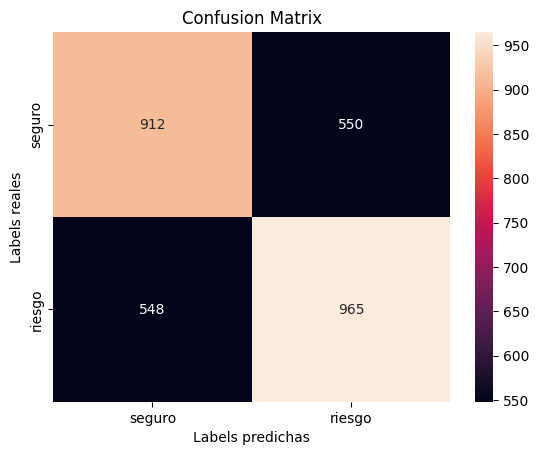

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, KFold

# Creamos un KFold para validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creamos el modelo base
model = KNC()

# Definir la red de hiperparámetros a ajustar
param_grid = {
    'n_neighbors': np.arange(1, 501, 50),   # corregido: empieza en 1
    'weights': ["uniform", "distance"],
}

# Búsqueda aleatoria de hiperparámetros
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=kf,
    n_iter=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Entrenamiento con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best model:", best_params)
print("\n")

# Modelo óptimo encontrado
best_model = grid_search.best_estimator_

# Evaluación del modelo final
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Etiquetas
ax.set_xlabel('Labels predichas')
ax.set_ylabel('Labels reales')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['seguro', 'riesgo'])
ax.yaxis.set_ticklabels(['seguro', 'riesgo'])

plt.show()


## Modelado 2

## Modelado 3

In [ ]:
import sys

# Listar TODAS las variables del entorno y sus tipos
vars_entorno = {k: type(v).__name__ for k, v in globals().items()}

# Filtrar solo DataFrames
dfs = {k: v for k, v in vars_entorno.items() if v == "DataFrame"}

dfs






{'__': 'DataFrame',
 '___': 'DataFrame',
 'data': 'DataFrame',
 '_16': 'DataFrame',
 'categorical_features': 'DataFrame',
 '_19': 'DataFrame',
 '_20': 'DataFrame',
 '_22': 'DataFrame',
 '_48': 'DataFrame',
 'target_data': 'DataFrame',
 '_52': 'DataFrame',
 'numerical_features': 'DataFrame',
 '_56': 'DataFrame',
 'safe_loans_raw': 'DataFrame',
 'risky_loans_raw': 'DataFrame',
 'risky_loans': 'DataFrame',
 'safe_loans': 'DataFrame',
 'data_clean': 'DataFrame',
 'data_cod': 'DataFrame',
 '_78': 'DataFrame',
 'data_scl': 'DataFrame',
 '_79': 'DataFrame',
 'df_challenge': 'DataFrame',
 '_90': 'DataFrame',
 '_101': 'DataFrame',
 '_104': 'DataFrame',
 '_111': 'DataFrame',
 'df_entrenamiento': 'DataFrame',
 'df': 'DataFrame',
 'df_challenge_aligned': 'DataFrame'}

## Evaluación final

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 1️⃣ Separar features y target
target_col = "bad_loans"

X = data_scl.drop(columns=[target_col])
y = data_scl[target_col]

print("✔ Dimensiones del dataset:")
print("X:", X.shape)
print("y:", y.shape)

# 2️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3️⃣ Crear el modelo
model = KNeighborsClassifier(n_neighbors=5)

# 4️⃣ Entrenar
model.fit(X_train, y_train)

print("\n🎯 Modelo entrenado correctamente.")


✔ Dimensiones del dataset:
X: (29749, 10)
y: (29749,)

🎯 Modelo entrenado correctamente.


In [ ]:
# Obtener columnas REALES usadas por el modelo
feature_cols = model.feature_names_in_

print("📌 Columnas reales del modelo:")
print(feature_cols)

# Alinear df_challenge
df_challenge_aligned = df_challenge.reindex(columns=feature_cols, fill_value=0)

print("\n✔ df_challenge alineado correctamente:")
print(df_challenge_aligned.head())
print("Shape:", df_challenge_aligned.shape)


📌 Columnas reales del modelo:
['emp_length_num' 'dti' 'last_delinq_none' 'last_major_derog_none'
 'revol_util' 'grade_cod' 'sub_grade_cod' 'home_ownership_cod'
 'purpose_cod' 'term_cod']

✔ df_challenge alineado correctamente:
   emp_length_num    dti  last_delinq_none  last_major_derog_none  revol_util  \
0               3   3.19                 1                      1        12.9   
1              11  14.88                 1                      1        44.9   
2               5  29.14                 1                      1        34.2   
3               7  24.02                 0                      0        44.6   
4               5  20.46                 1                      1        34.2   

   grade_cod  sub_grade_cod  home_ownership_cod  purpose_cod  term_cod  
0          0              0                   0            0         0  
1          0              0                   0            0         0  
2          0              0                   0            0       

In [ ]:
from sklearn.exceptions import NotFittedError
import pandas as pd

# Verificar si el modelo está entrenado
try:
    model.predict(df_challenge_aligned.iloc[:2])
    print("✔ Modelo verificado: está entrenado.")
except NotFittedError:
    raise ValueError("❌ El modelo no está entrenado. Ejecuta la CELDA 1.")

# Hacer predicción final
y_results = model.predict(df_challenge_aligned)

print("\n✔ Predicciones generadas:")
print(y_results[:10])

# Guardar archivo final
df_results = pd.DataFrame({"results": y_results})
df_results.to_csv("module5-challenge-tu_nombre.csv", index=False)

print("\n💾 Archivo creado: module5-challenge-tu_nombre.csv")
print("🎉 ¡CHALLENGE COMPLETADO!")


✔ Modelo verificado: está entrenado.

✔ Predicciones generadas:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

💾 Archivo creado: module5-challenge-tu_nombre.csv
🎉 ¡CHALLENGE COMPLETADO!


¡Al final! Cálcula la predicción con tu mejor modelo entrenado y envíalo a rubencpardo@gmail.com

RECUERDA: a los datos de evaluación del challenge tendrás que aplicarle previamente los mismos pasos de preprocesamiento que hayas utilizado para entrenar tu mejor modelo predictivo:
* Eliminación de variables
* Escalado
* Codificación


In [ ]:
import numpy as np
unique, counts = np.unique(y_results, return_counts=True)
dict(zip(unique, counts))


{np.float64(0.0): np.int64(20), np.float64(1.0): np.int64(2980)}

# ¿Cómo guardar los resultados de la evaluación para enviarlos?

In [ ]:
# Si es un numpy array
y_results = pd.DataFrame({"results": y_results})
y_results.to_csv("module5-challenge-tunombre.csv", index=False)

Descagarlo

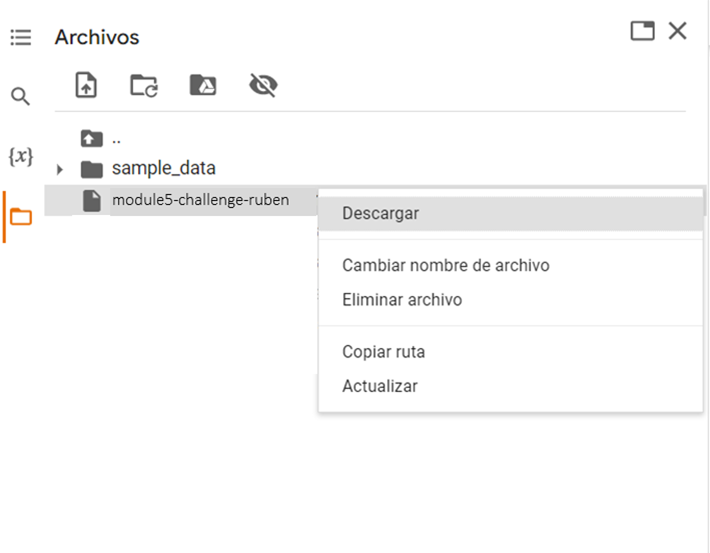

**¡Cuidado! Se puede bloquear la descarga de archivos desde Colab, tienes que permitirlo.**



-
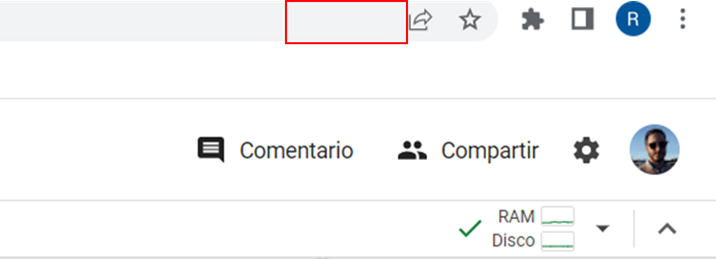